##### Imports

In [1]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
import yaml
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.linalg import block_diag
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from JOPLEn.multitask import MTJOPLEn
from JOPLEn.partitioner import VPartition, LinearForestPartition, GBPartition
from JOPLEn.enums import NormType
from sklearn.ensemble import GradientBoostingRegressor
from JOPLEn.singletask import JOPLEn
from collections import defaultdict
from JOPLEn.multitask import MTJOPLEn
from tqdm import trange


DATA_PATH = Path("..") / "datasets"

SARCOS_PATH = DATA_PATH / "sarcos" / "processed"
PARKINSONS_PATH = DATA_PATH / "parkinsons" / "processed"
NANO_PATH = DATA_PATH / "nanoparticle" / "processed"

NAMES = [
    "Dummy",
    "Linear",
    "Gradient Boosting",
    "JOPLEn",
    "Dirty LASSO",
]

OUT_PATH = Path("experiments") / "manual" / "multitask"

##### Function definitions

In [2]:
def train_model(ModelClass, x_train, y_train, x_val, y_val, x_test, y_test, **kwargs):
    output = {}
    model = ModelClass(**kwargs)

    for i in tqdm(range(len(x_train))):
        model.fit(x_train[i], y_train[i])

        output[f"task {i}"] = {
            "train": np.mean((model.predict(x_train[i]) - y_train[i]) ** 2),
            "val": np.mean((model.predict(x_val[i]) - y_val[i]) ** 2),
            "test": np.mean((model.predict(x_test[i]) - y_test[i]) ** 2),
        }
    return pd.DataFrame(output).T

In [3]:
def jp_mask(jp_model):
    core_mask = np.linalg.norm(jp_model.cwb.get()[:, :-1], axis=(0, 2)) > 1e-4
    task_mask = np.linalg.norm(jp_model.cws.get()[:, :-1], axis=2) > 1e-4

    task_mask = task_mask & ~core_mask[None, :]

    return core_mask, task_mask


def dl_mask(dl_model):
    core_mask = np.any(np.abs(dl_model.coef_shared_.T) > 1e-4, axis=0)
    task_mask = np.abs(dl_model.coef_specific_.T) > 1e-4

    task_mask = task_mask & ~core_mask[None, :]

    return core_mask, task_mask

In [4]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def dl_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2, axis=1)


def score_dl(model, x_train, y_train, x_val, y_val, x_test, y_test, masks=None):
    if masks is not None and len(masks) != 3:
        raise ValueError("You should include train, val, and test masks")

    if masks is None:
        train_mask = np.ones(x_train.shape[:2], dtype=bool)
        val_mask = np.ones(x_val.shape[:2], dtype=bool)
        test_mask = np.ones(x_test.shape[:2], dtype=bool)
    else:
        train_mask, val_mask, test_mask = masks

    y_train_err, y_val_err, y_test_err = [], [], []

    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    y_test_pred = model.predict(x_test)

    for i in range(x_train.shape[0]):
        y_train_err.append(
            mse(y_train[i, train_mask[i]], y_train_pred[i, train_mask[i]])
        )
        y_val_err.append(mse(y_val[i, val_mask[i]], y_val_pred[i, val_mask[i]]))
        y_test_err.append(mse(y_test[i, test_mask[i]], y_test_pred[i, test_mask[i]]))

    columns = ["train", "val", "test"]
    index = [f"task {i}" for i in range(x_train.shape[0])]

    return pd.DataFrame(
        np.array([y_train_err, y_val_err, y_test_err]).T,
        columns=columns,
        index=index,
    )


def dl_plot(model):
    fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True)

    axs[0].matshow(model.coef_shared_)
    axs[0].set_title("Shared Coefficients")

    axs[1].matshow(model.coef_specific_)
    axs[1].set_title("Specific Coefficients")

    for ax in axs:
        ax.set_ylabel("Features")
        ax.set_xlabel("Tasks")

    plt.tight_layout()

    core_mask, task_mask = dl_mask(model)

    print("Core features:", np.sum(core_mask))
    print(f"Task features: {list(np.sum(task_mask, axis=1))}: {np.sum(task_mask)}")

In [5]:
def scale_matrix(matrix, min_val, max_val):
    # Create an empty matrix of the same shape to store the scaled values
    scaled_matrix = np.zeros_like(matrix)

    assert min_val < 0 and max_val > 0, "min_val and max_val must have opposite signs"

    abs_max = max(abs(min_val), abs(max_val))

    # Handle negative and zero values
    neg_mask = matrix <= 0
    scaled_matrix[neg_mask] = matrix[neg_mask] / abs_max

    # Handle positive values
    pos_mask = matrix > 0
    scaled_matrix[pos_mask] = matrix[pos_mask] / abs_max

    return scaled_matrix


def plot_joplen_weights(model, dpi=300):
    # get weights without bias term
    core_weights = model.cwb.get()[:, :-1]
    task_weights = model.cws.get()[:, :-1]

    min_val = min(core_weights.min(), task_weights.min())
    max_val = max(core_weights.max(), task_weights.max())

    n_tasks, n_feats, n_cells = core_weights.shape
    core_weights = core_weights.transpose(1, 0, 2).reshape(n_feats, -1)
    task_weights = task_weights.transpose(1, 0, 2).reshape(n_feats, -1)

    core_weights = scale_matrix(core_weights, min_val, max_val)
    task_weights = scale_matrix(task_weights, min_val, max_val)

    fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True, dpi=dpi)

    params = {"aspect": "auto", "vmin": -1, "vmax": 1, "cmap": "seismic"}

    axs[0].matshow(core_weights, **params)
    axs[0].set_title("Core Weights")
    axs[1].matshow(task_weights, **params)
    axs[1].set_title("Task Weights")

    # create a vertical line between each task
    for ax in axs:
        for i in range(n_tasks - 1):
            ax.axvline((i + 1) * n_cells, color="k", linewidth=1, alpha=0.25)

    for ax in axs:
        ax.set_xlabel("Tasks, partitions, and cells")
        ax.set_ylabel("Features")

    plt.tight_layout()
    plt.show()

    # print the number of weights that are nonzero
    core_mask, task_mask = jp_mask(model)

    print(f"Number of nonzero core weights: {core_mask.sum()}")
    print(
        f"Number of nonzero task weights: {list(task_mask.sum(axis=1))}: {task_mask.sum()}"
    )

In [6]:
def score_jp(model: MTJOPLEn, x_train, y_train, x_val, y_val, x_test, y_test):
    y_train_err = []
    y_val_err = []
    y_test_err = []

    for i in range(len(x_train)):
        y_train_err.append(mse(y_train[i], model.predict(x_train[i], i).flatten()))
        y_val_err.append(mse(y_val[i], model.predict(x_val[i], i).flatten()))
        y_test_err.append(mse(y_test[i], model.predict(x_test[i], i).flatten()))

    columns = ["train", "val", "test"]
    index = [f"task {i}" for i in range(len(x_train))]

    return pd.DataFrame(
        np.array([y_train_err, y_val_err, y_test_err]).T,
        columns=columns,
        index=index,
    )


def compare_feats(jp_model, dl_model):
    jp_core_feats, jp_task_feats = jp_mask(jp_model)
    dl_core_feats, dl_task_feats = dl_mask(dl_model)

    results = [
        np.sum(jp_core_feats | jp_task_feats, axis=1),
        np.sum(dl_core_feats | dl_task_feats, axis=1),
    ]

    df = pd.DataFrame(results, columns=[f"task_{i}" for i in range(len(jp_task_feats))])
    df.index = ["JOPLEn", "Dirty LASSO"]

    return df


def train_masked_gb(
    x_train, y_train, x_val, y_val, x_test, y_test, core_mask, task_mask
):
    both_masks = core_mask | task_mask

    errors = []

    for i in trange(len(x_train)):
        model = GradientBoostingRegressor()
        model.fit(x_train[i][:, both_masks[i]], y_train[i])

        errors.append(
            {
                "train": mse(y_train[i], model.predict(x_train[i][:, both_masks[i]])),
                "val": mse(y_val[i], model.predict(x_val[i][:, both_masks[i]])),
                "test": mse(y_test[i], model.predict(x_test[i][:, both_masks[i]])),
            }
        )

    return pd.DataFrame(errors)

In [7]:
def plot_strip(
    arr: list[np.ndarray],
    jitter: float = 0.2,
    random_state: int = 0,
    plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
    ax=None,
):
    """
    Create a strip plot based on the list of y-values.
    """
    if ax is None:
        fig, ax = plt.subplots(**plot_kwargs)

    np.random.seed(random_state)
    y_values = np.arange(len(arr))[:, None] + np.random.uniform(
        -jitter, jitter, size=arr.shape
    )

    for xs, ys in zip(arr, y_values):
        ax.scatter(xs, ys, **scatter_kwargs)

    # for x_idx, x_values in enumerate(arr):
    #     # Apply jitter to x-axis positions
    #     y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in x_values]
    #     ax.scatter(x_values, y_values, **scatter_kwargs)

    x_lim = ax.get_xlim()

    for x_idx, x_values in enumerate(arr[:-1]):
        ax.hlines(x_idx + 1 / 2, *x_lim, color="k", alpha=0.25)

    ax.set_xlim(x_lim)
    ax.set_ylim(-0.5, len(arr) - 0.5)

    return ax, y_values

In [8]:
def concat_datasets(
    X_datasets: list[np.ndarray], y_datasets: list[np.ndarray]
) -> tuple[np.ndarray]:
    padded_y = []
    padded_X = []
    mask = []

    num_datasets = len(y_datasets)
    basis = np.eye(num_datasets, dtype=bool)

    for i, (y, X, b) in enumerate(zip(y_datasets, X_datasets, basis)):
        y = np.expand_dims(y, 0)
        X = np.expand_dims(X, 0)
        b = np.expand_dims(b, 1)

        task_padding = (i, num_datasets - i - 1)

        tmp_y = np.pad(y, [task_padding, (0, 0)], mode="constant")
        tmp_X = np.tile(X, (num_datasets, 1, 1))
        tmp_b = np.tile(b, (1, y.shape[1]))

        padded_y.append(tmp_y)
        padded_X.append(tmp_X)
        mask.append(tmp_b)

    y_out = np.concatenate(padded_y, axis=-1)
    x_out = np.concatenate(padded_X, axis=1)
    mask_out = np.concatenate(mask, axis=-1)

    return x_out, y_out, mask_out


def get_out_data(y_pred, mask_out):
    indices = [0] + list(np.cumsum(mask_out.sum(axis=1)))[:-1] + [None]
    tmp = y_pred[mask_out]
    return [tmp[i1:i2] for i1, i2 in zip(indices[:-1], indices[1:])]

In [9]:
def scatter_test(x_data, y_data, x_name, y_name):
    plt.scatter(x_data["test"], y_data["test"])

    xlim, ylim = plt.xlim(), plt.ylim()

    max_val = max(xlim[1], ylim[1])

    plt.plot([0, 10], [0, 10], "k--")
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.gca().set_aspect("equal")

    plt.xlabel(x_name)
    plt.ylabel(y_name)

    plt.show()

In [10]:
def save_results(
    dataset,
    jp_res,
    dl_res,
    dummy_results,
    linear_results,
    gb_results,
    jp_model,
    dl_model,
):
    path = OUT_PATH / dataset

    path.mkdir(parents=True, exist_ok=True)

    # prediction performance
    jp_res.to_csv(path / "joplen.csv")
    dl_res.to_csv(path / "dl.csv")
    dummy_results.to_csv(path / "dummy.csv")
    linear_results.to_csv(path / "linear.csv")
    gb_results.to_csv(path / "gb.csv")

    # weights
    jp_path = path / "joplen"
    jp_path.mkdir(parents=True, exist_ok=True)
    np.save(jp_path / "core.npy", jp_model.cwb.get())
    np.save(jp_path / "task.npy", jp_model.cws.get())

    dl_path = path / "dirty_lasso"
    dl_path.mkdir(parents=True, exist_ok=True)
    np.save(dl_path / "core.npy", dl_model.coef_shared_)
    np.save(dl_path / "task.npy", dl_model.coef_specific_)


def load_results(dataset):
    path = OUT_PATH / dataset

    # prediction performance
    jp_res = pd.read_csv(path / "joplen.csv", index_col=0)
    dl_res = pd.read_csv(path / "dl.csv", index_col=0)
    dummy_results = pd.read_csv(path / "dummy.csv", index_col=0)
    linear_results = pd.read_csv(path / "linear.csv", index_col=0)
    gb_results = pd.read_csv(path / "gb.csv", index_col=0)

    # weights
    jp_path = path / "joplen"
    jp_core = np.load(jp_path / "core.npy")
    jp_task = np.load(jp_path / "task.npy")

    dl_path = path / "dirty_lasso"
    dl_core = np.load(dl_path / "core.npy")
    dl_task = np.load(dl_path / "task.npy")

    return (
        jp_res,
        dl_res,
        dummy_results,
        linear_results,
        gb_results,
        jp_core,
        jp_task,
        dl_core,
        dl_task,
    )

##### SARCOS

In [11]:
# try sarcos

x_train = np.loadtxt(SARCOS_PATH / "x_train.csv", delimiter=",")
x_val = np.loadtxt(SARCOS_PATH / "x_val.csv", delimiter=",")
x_test = np.loadtxt(SARCOS_PATH / "x_test.csv", delimiter=",")

y_train = np.loadtxt(SARCOS_PATH / "y_train.csv", delimiter=",")
y_val = np.loadtxt(SARCOS_PATH / "y_val.csv", delimiter=",")
y_test = np.loadtxt(SARCOS_PATH / "y_test.csv", delimiter=",")

x_ss = StandardScaler()
x_train = x_ss.fit_transform(x_train)
x_val = x_ss.transform(x_val)
x_test = x_ss.transform(x_test)

y_ss = StandardScaler()
y_train = y_ss.fit_transform(y_train)
y_val = y_ss.transform(y_val)
y_test = y_ss.transform(y_test)

print(x_train.shape, y_train.shape)

n_tasks = y_train.shape[1]

x_train = np.tile(x_train, (n_tasks, 1, 1))
x_val = np.tile(x_val, (n_tasks, 1, 1))
x_test = np.tile(x_test, (n_tasks, 1, 1))

y_train = np.transpose(y_train)
y_val = np.transpose(y_val)
y_test = np.transpose(y_test)

print(x_train.shape, y_train.shape)

(34262, 21) (34262, 7)
(7, 34262, 21) (7, 34262)


In [12]:
shared_params = {
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    "x_test": x_test,
    "y_test": y_test,
}

dummy_results = train_model(DummyRegressor, **shared_params, strategy="mean")
linear_results = train_model(Ridge, **shared_params)
gb_results = train_model(
    LGBMRegressor,
    random_state=0,
    n_estimators=100,
    max_depth=3,
    verbose=-1,
    **shared_params,
)

print("Dummy Results")
display(dummy_results.round(3))
print("Linear Results")
display(linear_results.round(3))
print("GB Results")
display(gb_results.round(3))

100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

Dummy Results


,train,val,test
task 0,1.0,1.032,0.983
task 1,1.0,1.011,0.978
task 2,1.0,1.019,0.991
task 3,1.0,1.020,0.979
task 4,1.0,1.037,1.010
task 5,1.0,0.994,0.973
task 6,1.0,1.010,0.984


Linear Results


,train,val,test
task 0,0.074,0.074,0.074
task 1,0.103,0.102,0.102
task 2,0.091,0.094,0.090
task 3,0.051,0.053,0.050
task 4,0.146,0.151,0.144
task 5,0.274,0.277,0.271
task 6,0.065,0.067,0.064


GB Results


,train,val,test
task 0,0.059,0.063,0.060
task 1,0.060,0.063,0.062
task 2,0.060,0.063,0.062
task 3,0.024,0.026,0.026
task 4,0.081,0.088,0.086
task 5,0.102,0.109,0.105
task 6,0.037,0.039,0.040


Core features: 5
Task features: [3, 3, 3, 2, 8, 5, 3]: 27


,train,val,test
task 0,0.105,0.103,0.104
task 1,0.125,0.124,0.121
task 2,0.107,0.110,0.102
task 3,0.070,0.071,0.069
task 4,0.194,0.201,0.192
task 5,0.335,0.337,0.327
task 6,0.095,0.096,0.095


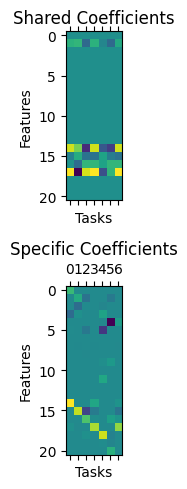

In [13]:
from mutar import DirtyModel

dl_model = DirtyModel(
    alpha=0.1,  # shared penalty
    beta=0.0442,  # task-specific penalty
)
dl_model.fit(x_train, y_train)

dl_plot(dl_model)

dl_res = score_dl(dl_model, x_train, y_train, x_val, y_val, x_test, y_test)
display(dl_res.round(3))

In [15]:
vpart_params = (
    {"n_partitions": 100, "n_cells": 8},
    {
        "max_iters": 2000,
        "lam_core": 0.7,
        "lam_task": 0.3,
        "core_alpha": 0.0,
        "task_alpha": 0.0,
        "print_epochs": 100,
        "mu": 1e-3,
    },
)

jp_model = MTJOPLEn(
    # GBPartition,
    VPartition,
    **vpart_params[0],
    random_state=0,
)
history = jp_model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    **vpart_params[1],
    verbose=True,
)

Partition tasks: 100%|██████████| 7/7 [00:00<00:00, 3221.43it/s]


[19:16:55]: Epoch    100 | TrL: 0.383714, 0.358748, 0.326798, 0.299332, 0.389312, 0.443341, 0.313491 | VaL: 0.383818, 0.355524, 0.328415, 0.303494, 0.395946, 0.442243, 0.314392 | CNorm: 0.467609 | TNorm: 0.912001 | CFNorm: 0.023392 | TFNorm: 0.023392 | WbNz:   17 | WsNz:    0,    0,    0,    0,    1,    3,    1
[19:16:57]: Epoch    200 | TrL: 0.352791, 0.338747, 0.308654, 0.276519, 0.380251, 0.429927, 0.292694 | VaL: 0.352642, 0.335905, 0.310461, 0.280014, 0.386169, 0.429275, 0.293072 | CNorm: 0.428126 | TNorm: 0.841017 | CFNorm: 0.032525 | TFNorm: 0.032525 | WbNz:   12 | WsNz:    0,    1,    0,    0,    1,    6,    0
[19:16:58]: Epoch    300 | TrL: 0.341568, 0.330705, 0.303648, 0.270964, 0.375302, 0.425270, 0.287054 | VaL: 0.341352, 0.328094, 0.305341, 0.274218, 0.380668, 0.425119, 0.287180 | CNorm: 0.376042 | TNorm: 0.810669 | CFNorm: 0.039660 | TFNorm: 0.039660 | WbNz:   10 | WsNz:    1,    1,    0,    0,    1,    4,    0
[19:16:59]: Epoch    400 | TrL: 0.334259, 0.328343, 0.301008,

,train,val,test
task 0,0.102,0.102,0.097
task 1,0.108,0.108,0.109
task 2,0.098,0.100,0.094
task 3,0.075,0.078,0.074
task 4,0.133,0.137,0.134
task 5,0.184,0.187,0.180
task 6,0.087,0.088,0.087


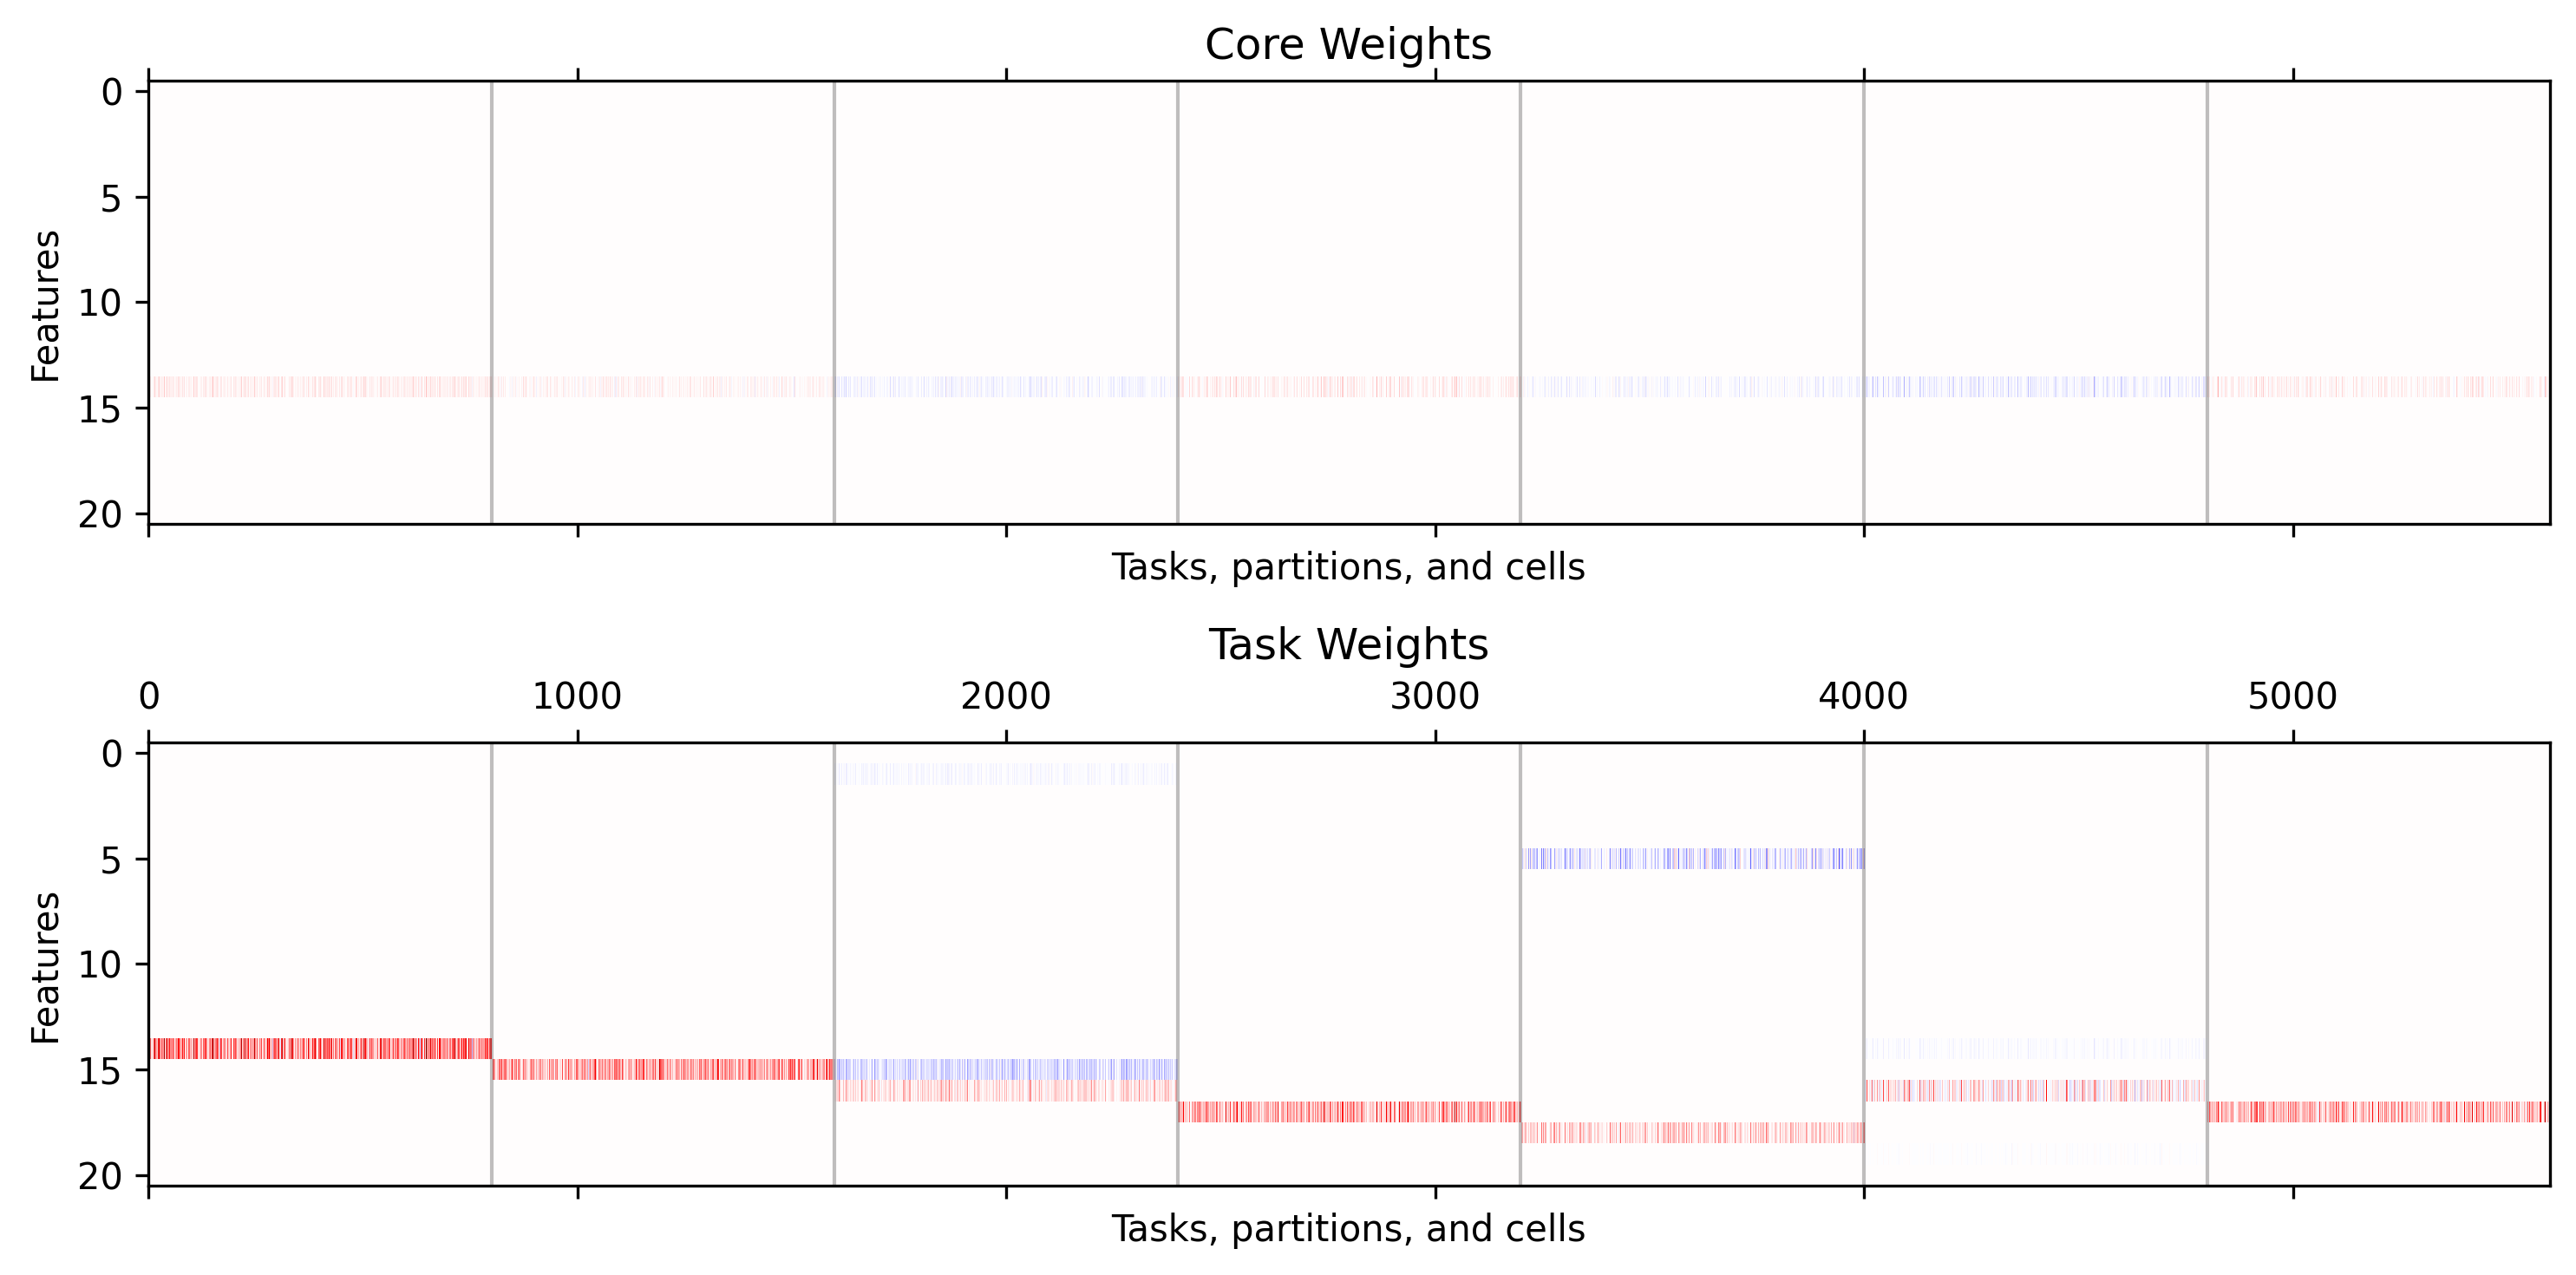

Number of nonzero core weights: 1
Number of nonzero task weights: [0, 1, 3, 1, 2, 2, 1]: 10


In [16]:
jp_res = score_jp(jp_model, x_train, y_train, x_val, y_val, x_test, y_test)

display(jp_res.round(3))

plot_joplen_weights(jp_model)

In [17]:
sarcos_df = compare_feats(jp_model, dl_model)
sarcos_df

,task_0,task_1,task_2,task_3,task_4,task_5,task_6
JOPLEn,1,2,4,2,3,3,2
Dirty LASSO,8,8,8,7,13,10,8


In [19]:
train_masked_gb(x_train, y_train, x_val, y_val, x_test, y_test, *jp_mask(jp_model))

100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


,train,val,test
0,0.471813,0.473425,0.475222
1,0.262406,0.271811,0.269906
2,0.069378,0.074202,0.072550
3,0.076586,0.082108,0.079372
4,0.226316,0.238769,0.236555
5,0.529263,0.551274,0.532372
6,0.099899,0.103346,0.100894


In [20]:
train_masked_gb(x_train, y_train, x_val, y_val, x_test, y_test, *dl_mask(dl_model))

100%|██████████| 7/7 [00:45<00:00,  6.57s/it]


,train,val,test
0,0.067475,0.072042,0.071489
1,0.062532,0.065432,0.063806
2,0.063615,0.068640,0.067511
3,0.033592,0.035855,0.036393
4,0.082660,0.090171,0.087312
5,0.122248,0.129766,0.126178
6,0.049196,0.051793,0.052734


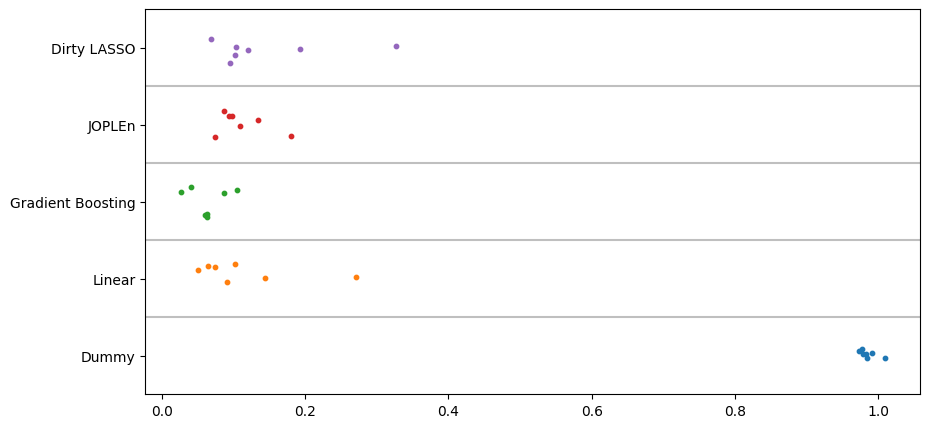

In [21]:
scores = [dummy_results, linear_results, gb_results, jp_res, dl_res]
scores = np.array([s["test"].to_numpy() for s in scores])

plot_strip(
    scores,
    plot_kwargs={"figsize": (10, 5)},
    scatter_kwargs={"alpha": 1.0, "s": 10},
)
plt.yticks(np.arange(len(NAMES)), NAMES)

plt.show()

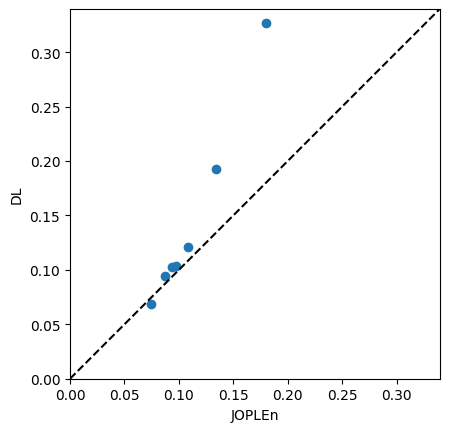

In [22]:
scatter_test(jp_res, dl_res, "JOPLEn", "DL")
# DL worse in 2 of the 5, otherwise basically the same

In [23]:
jp_res

,train,val,test
task 0,0.101785,0.102165,0.097362
task 1,0.108496,0.108368,0.108763
task 2,0.097830,0.099590,0.093544
task 3,0.075436,0.077906,0.074437
task 4,0.133125,0.136970,0.133973
task 5,0.183646,0.187108,0.179855
task 6,0.087035,0.087559,0.087009


In [24]:
# save results for plotting
save_results(
    "sarcos",
    jp_res,
    dl_res,
    dummy_results,
    linear_results,
    gb_results,
    jp_model,
    dl_model,
)

---

##### Parkinsons

In [27]:
# try parkinsons

train = {}
val = {}
test = {}

for dir in sorted(PARKINSONS_PATH.iterdir(), key=lambda x: int(x.name)):
    x_train = np.loadtxt(dir / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(dir / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(dir / "x_test.csv", delimiter=",")

    x_ss = StandardScaler()
    x_train = x_ss.fit_transform(x_train)
    x_val = x_ss.transform(x_val)
    x_test = x_ss.transform(x_test)

    y_train = np.loadtxt(dir / "y_train.csv", delimiter=",")[:, None]
    y_val = np.loadtxt(dir / "y_val.csv", delimiter=",")[:, None]
    y_test = np.loadtxt(dir / "y_test.csv", delimiter=",")[:, None]

    y_ss = StandardScaler()
    y_train = y_ss.fit_transform(y_train).flatten()
    y_val = y_ss.transform(y_val).flatten()
    y_test = y_ss.transform(y_test).flatten()

    train[int(dir.name)] = {"x": x_train, "y": y_train}
    val[int(dir.name)] = {"x": x_val, "y": y_val}
    test[int(dir.name)] = {"x": x_test, "y": y_test}

# print number of features and samples
print(x_train.shape)

(105, 18)


In [28]:
n_tasks = len(train)
participants = list(train.keys())

x_train = [train[i]["x"] for i in participants]
x_val = [val[i]["x"] for i in participants]
x_test = [test[i]["x"] for i in participants]

y_train = [train[i]["y"] for i in participants]
y_val = [val[i]["y"] for i in participants]
y_test = [test[i]["y"] for i in participants]

In [29]:
shared_params = {
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    "x_test": x_test,
    "y_test": y_test,
}

dummy_results = train_model(DummyRegressor, **shared_params, strategy="mean")
linear_results = train_model(LinearRegression, **shared_params)
gb_results = train_model(
    LGBMRegressor,
    random_state=0,
    n_estimators=100,
    max_depth=3,
    verbose=-1,
    **shared_params,
)

print("Dummy Results")
display(dummy_results.round(3))
print("Linear Results")
display(linear_results.round(3))
print("GB Results")
display(gb_results.round(3))

100%|██████████| 42/42 [00:00<00:00, 197.55it/s]

Dummy Results


,train,val,test
task 0,1.0,1.062,1.008
task 1,1.0,0.914,1.110
task 2,1.0,0.852,0.726
task 3,1.0,1.169,0.662
task 4,1.0,0.793,1.129
task 5,1.0,1.081,0.873
task 6,1.0,1.023,0.503
task 7,1.0,1.068,0.718
task 8,1.0,1.497,0.964
task 9,1.0,0.863,0.904


Linear Results


,train,val,test
task 0,0.684,1.086,1.411
task 1,0.693,0.564,0.693
task 2,0.664,1.462,0.971
task 3,0.504,0.796,0.572
task 4,0.677,1.208,0.857
task 5,0.565,2.131,1.006
task 6,0.677,1.210,0.325
task 7,0.867,1.173,0.858
task 8,0.798,1.341,0.971
task 9,0.692,1.059,1.145


GB Results


,train,val,test
task 0,0.270,1.308,1.019
task 1,0.329,0.799,0.756
task 2,0.183,0.583,0.942
task 3,0.280,0.996,0.507
task 4,0.331,1.060,1.058
task 5,0.212,1.226,0.551
task 6,0.319,1.118,0.630
task 7,0.381,0.985,1.195
task 8,0.358,1.465,0.742
task 9,0.282,0.990,0.797


In [ ]:
plt.scatter(dummy_results, gb_results)

In [ ]:
from JOPLEn.partitioner import VPartition, RFPartition, GBPartition

jp_model = MTJOPLEn(
    # GBPartition,
    VPartition,
    n_partitions=100,
    # n_partitions=1000,
    n_cells=8,
    random_state=0,
)

history = jp_model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    max_iters=1000,
    lam_core=2.5,
    lam_task=0.5,
    core_alpha=0.0,
    task_alpha=0.0,
    print_epochs=100,
    mu=1e-3,
)

Partition tasks: 100%|██████████| 42/42 [00:00<00:00, 3268.11it/s]


[12:09:22]: Epoch    100 | TrL: 0.747913, 0.757689, 0.689792, 0.712806, 0.734913, 0.720231, 0.729358, 0.858267, 0.791867, 0.762715, 0.795933, 0.685708, 0.673107, 0.777327, 0.543986, 0.712156, 0.769563, 0.626812, 0.812795, 0.761491, 0.680451, 0.766311, 0.738721, 0.807256, 0.736516, 0.754834, 0.690901, 0.793045, 0.740855, 0.799394, 0.704043, 0.752169, 0.704503, 0.828139, 0.774016, 0.758283, 0.663865, 0.805909, 0.814953, 0.821756, 0.794447, 0.767768 | VaL: 0.991044, 0.689669, 0.822673, 0.942966, 0.953596, 0.949391, 0.973434, 0.950832, 1.184141, 0.914623, 1.058877, 0.989482, 0.814871, 0.942703, 0.807410, 1.036923, 1.033908, 0.773375, 0.994374, 1.094776, 0.978464, 1.031198, 0.756776, 1.252994, 1.002823, 0.963217, 0.900483, 1.352170, 0.874426, 0.972478, 0.960446, 0.883476, 1.082855, 1.049021, 1.028992, 1.045371, 0.868953, 0.976117, 1.064038, 1.182505, 0.918191, 0.932145 | CNorm: 0.871773 | TNorm: 1.518035 | CFNorm: 0.022213 | TFNorm: 0.022213 | WbNz:   16 | WsNz:    0,    0,    0,    0,    0

,train,val,test
task 0,0.323,1.080,1.255
task 1,0.354,0.455,1.047
task 2,0.244,0.734,0.624
task 3,0.273,0.884,0.417
task 4,0.287,0.956,0.943
task 5,0.332,0.883,0.372
task 6,0.308,1.037,0.517
task 7,0.423,0.989,1.138
task 8,0.354,1.594,0.792
task 9,0.297,0.930,1.087


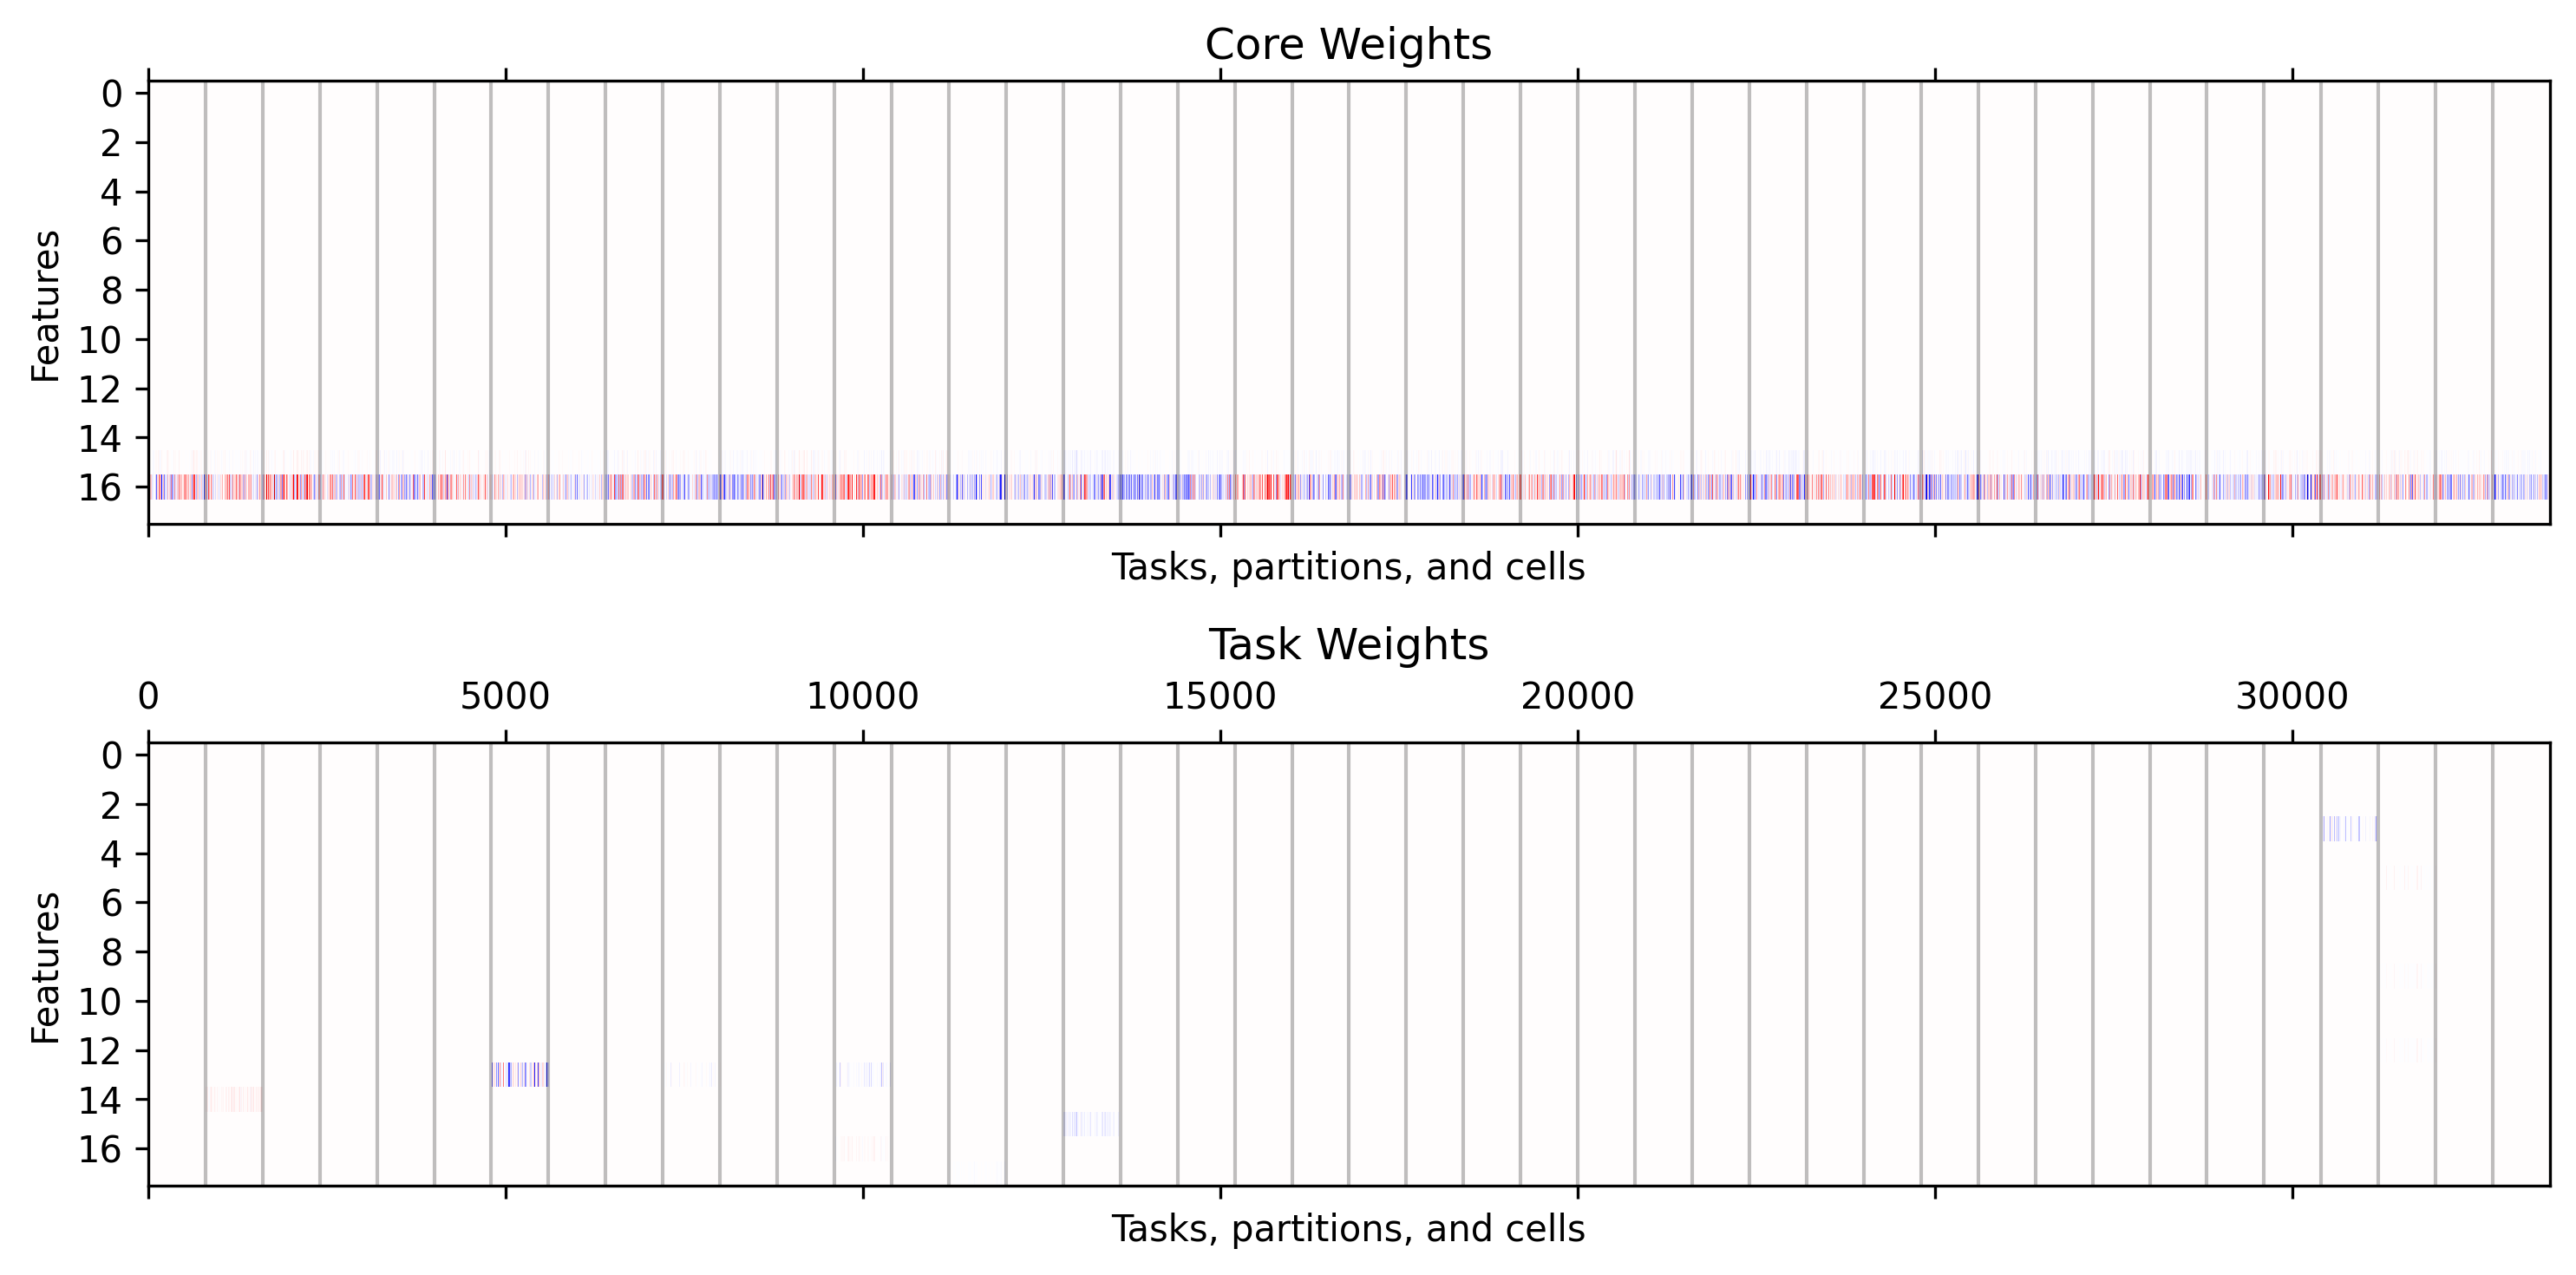

Number of nonzero core weights: 2
Number of nonzero task weights: [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0]: 9


In [ ]:
jp_res = score_jp(jp_model, x_train, y_train, x_val, y_val, x_test, y_test)

display(jp_res.round(3))

plot_joplen_weights(jp_model)

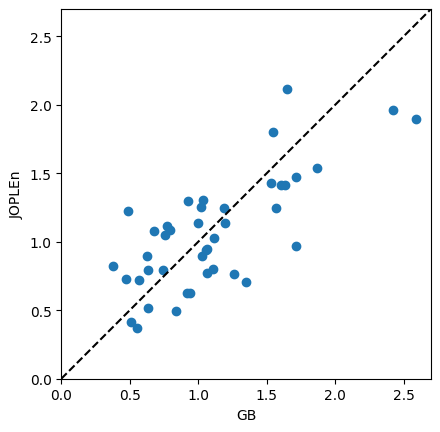

In [ ]:
scatter_test(gb_results, jp_res, "GB", "JOPLEn")

In [ ]:
from mutar import DirtyModel

x_train_out, y_train_out, train_mask_out = concat_datasets(x_train, y_train)
x_val_out, y_val_out, val_mask_out = concat_datasets(x_val, y_val)
x_test_out, y_test_out, test_mask_out = concat_datasets(x_test, y_test)

dl_model = DirtyModel(
    alpha=0.015,  # shared penalty
    beta=0.005,  # task-specific penalty
)
dl_model.fit(x_train_out, y_train_out, train_mask_out)

DirtyModel(alpha=0.015, beta=0.005)

Core features: 4
Task features: [0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]: 9


,train,val,test
task 0,0.822,0.996,1.183
task 1,0.899,0.726,0.808
task 2,0.851,0.713,0.705
task 3,0.838,1.039,0.627
task 4,0.893,0.836,1.018
task 5,0.848,0.930,0.650
task 6,0.875,0.908,0.445
task 7,0.988,1.001,0.732
task 8,0.960,1.437,0.952
task 9,0.919,0.861,0.800


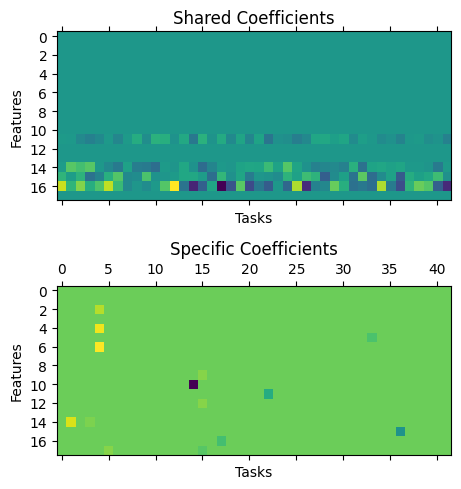

In [ ]:
dl_plot(dl_model)

dl_res = score_dl(
    dl_model,
    x_train_out,
    y_train_out,
    x_val_out,
    y_val_out,
    x_test_out,
    y_test_out,
    masks=[train_mask_out, val_mask_out, test_mask_out],
)
display(dl_res.round(3))  # 4,9

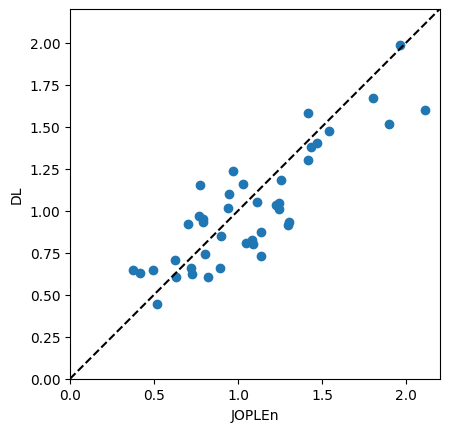

In [ ]:
scatter_test(jp_res, dl_res, "JOPLEn", "DL")

In [ ]:
feats_df = compare_feats(jp_model, dl_model)
feats_df

,task_0,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,...,task_32,task_33,task_34,task_35,task_36,task_37,task_38,task_39,task_40,task_41
JOPLEn,2,3,2,2,2,2,3,2,2,3,...,2,2,2,2,2,2,3,5,2,2
Dirty LASSO,4,4,4,4,7,5,4,4,4,4,...,4,5,4,4,4,4,4,4,4,4


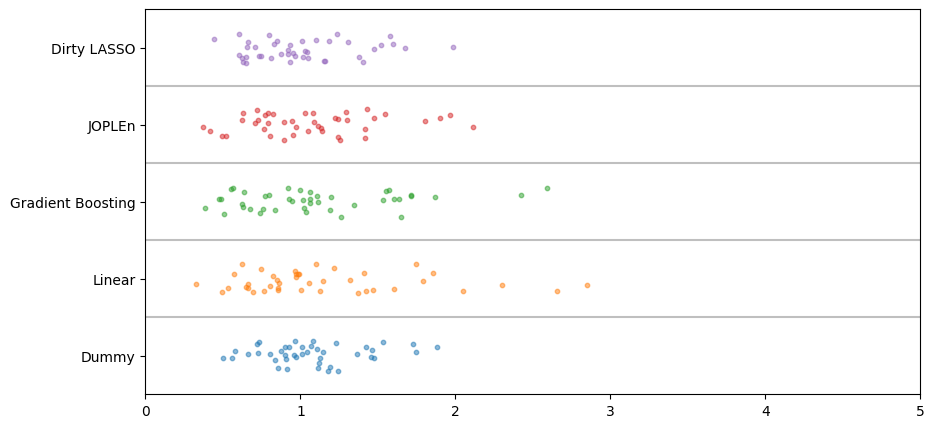

In [ ]:
scores = [dummy_results, linear_results, gb_results, jp_res, dl_res]
scores = np.array([s["test"].to_numpy() for s in scores])

plot_strip(
    scores,
    plot_kwargs={"figsize": (10, 5)},
    scatter_kwargs={"alpha": 0.5, "s": 10},
)
plt.yticks(np.arange(len(NAMES)), NAMES)

plt.xlim(0, 5)

plt.show()

In [ ]:
# save results for plotting
save_results(
    "parkinsons",
    jp_res,
    dl_res,
    dummy_results,
    linear_results,
    gb_results,
    jp_model,
    dl_model,
)

---

##### Nanoparticle

In [ ]:
train = {}
val = {}
test = {}

dirs = sorted(NANO_PATH.iterdir())
dir_names = [dir.name for dir in dirs]

for dir in dirs:
    x_train = np.loadtxt(dir / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(dir / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(dir / "x_test.csv", delimiter=",")

    x_ss = StandardScaler()
    x_train = x_ss.fit_transform(x_train)
    x_val = x_ss.transform(x_val)
    x_test = x_ss.transform(x_test)

    y_train = np.loadtxt(dir / "y_train.csv", delimiter=",")[:, None]
    y_val = np.loadtxt(dir / "y_val.csv", delimiter=",")[:, None]
    y_test = np.loadtxt(dir / "y_test.csv", delimiter=",")[:, None]

    y_ss = StandardScaler()
    y_train = y_ss.fit_transform(y_train).flatten()
    y_val = y_ss.transform(y_val).flatten()
    y_test = y_ss.transform(y_test).flatten()

    train[dir.name] = {"x": x_train, "y": y_train}
    val[dir.name] = {"x": x_val, "y": y_val}
    test[dir.name] = {"x": x_test, "y": y_test}

    print(dir.name)

mol_boil
mol_henry


mol_logp
mol_melt
np_logp
np_zetap
protein_sol


In [ ]:
n_tasks = len(train)
participants = list(train.keys())

x_train = [train[i]["x"] for i in participants]
x_val = [val[i]["x"] for i in participants]
x_test = [test[i]["x"] for i in participants]

y_train = [train[i]["y"] for i in participants]
y_val = [val[i]["y"] for i in participants]
y_test = [test[i]["y"] for i in participants]

In [ ]:
shared_params = {
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    "x_test": x_test,
    "y_test": y_test,
}

dummy_results = train_model(DummyRegressor, **shared_params, strategy="mean")
# TODO: Linear regression is flipping out because it's underdetermined?
linear_results = train_model(Ridge, **shared_params)
gb_results = train_model(
    LGBMRegressor,
    random_state=0,
    n_estimators=100,
    max_depth=3,
    verbose=-1,
    **shared_params,
)

print("Dummy Results")
display(dummy_results.round(3))
print("Linear Results")
display(linear_results.round(3))
print("GB Results")
display(gb_results.round(3))

100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

Dummy Results


,train,val,test
task 0,1.0,0.878,0.704
task 1,1.0,0.795,0.841
task 2,1.0,1.019,1.004
task 3,1.0,1.059,0.923
task 4,1.0,1.151,1.359
task 5,1.0,1.461,1.037
task 6,1.0,1.029,0.976


Linear Results


,train,val,test
task 0,0.327,0.969,0.745
task 1,0.113,1.365,0.393
task 2,0.302,27443.136,0.330
task 3,0.261,0.828,0.576
task 4,0.058,2.707,4.381
task 5,0.084,2.408,0.504
task 6,0.696,1.003,1.000


GB Results


,train,val,test
task 0,0.202,0.549,0.478
task 1,0.067,0.250,0.190
task 2,0.251,0.299,0.293
task 3,0.179,0.308,0.336
task 4,0.020,0.284,0.285
task 5,0.033,0.389,0.262
task 6,0.493,0.729,0.817


In [ ]:
jp_model = MTJOPLEn(
    # GBPartition,
    # n_partitions=100,
    VPartition,
    n_partitions=100,
    n_cells=8,
    random_state=0,
)

history = jp_model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    max_iters=10000,
    lam_core=2.04,
    lam_task=1.1,
    # lam_core=1.6,
    # lam_task=1.25,
    core_alpha=0.0,
    task_alpha=0.0,
    print_epochs=100,
    mu=1e-5,
    rel_lr=[1] * 4 + [1.5] + [1] * 2,
)

Partition tasks: 100%|██████████| 7/7 [00:00<00:00, 1315.59it/s]


[12:10:13]: Epoch    100 | TrL: 0.951155, 0.897384, 0.925133, 0.939271, 0.795661, 0.892198, 0.990024 | VaL: 0.896768, 0.824317, 0.932868, 0.964473, 0.887731, 1.151265, 1.004667 | CNorm: 0.077535 | TNorm: 0.138640 | CFNorm: 0.000049 | TFNorm: 0.000049 | WbNz:    3 | WsNz:    0,    0,    0,    0,    2,    0,    0
[12:10:15]: Epoch    200 | TrL: 0.941569, 0.879383, 0.902966, 0.926162, 0.757178, 0.882311, 0.987210 | VaL: 0.889203, 0.810610, 0.909445, 0.950658, 0.851423, 1.133050, 1.001827 | CNorm: 0.086718 | TNorm: 0.162643 | CFNorm: 0.000097 | TFNorm: 0.000097 | WbNz:   12 | WsNz:    0,    0,    0,    0,   11,    0,    0
[12:10:16]: Epoch    300 | TrL: 0.936072, 0.870171, 0.892382, 0.919468, 0.737130, 0.876470, 0.985588 | VaL: 0.884943, 0.802962, 0.898191, 0.943957, 0.829628, 1.124438, 1.000139 | CNorm: 0.088638 | TNorm: 0.175228 | CFNorm: 0.000143 | TFNorm: 0.000143 | WbNz:   40 | WsNz:    0,    0,    0,    0,   15,    0,    0
[12:10:17]: Epoch    400 | TrL: 0.932788, 0.863075, 0.885756,

,train,val,test
task 0,0.754,0.720,0.553
task 1,0.587,0.548,0.523
task 2,0.685,0.699,0.681
task 3,0.686,0.718,0.656
task 4,0.369,0.477,0.841
task 5,0.655,1.243,0.862
task 6,0.906,0.924,0.925


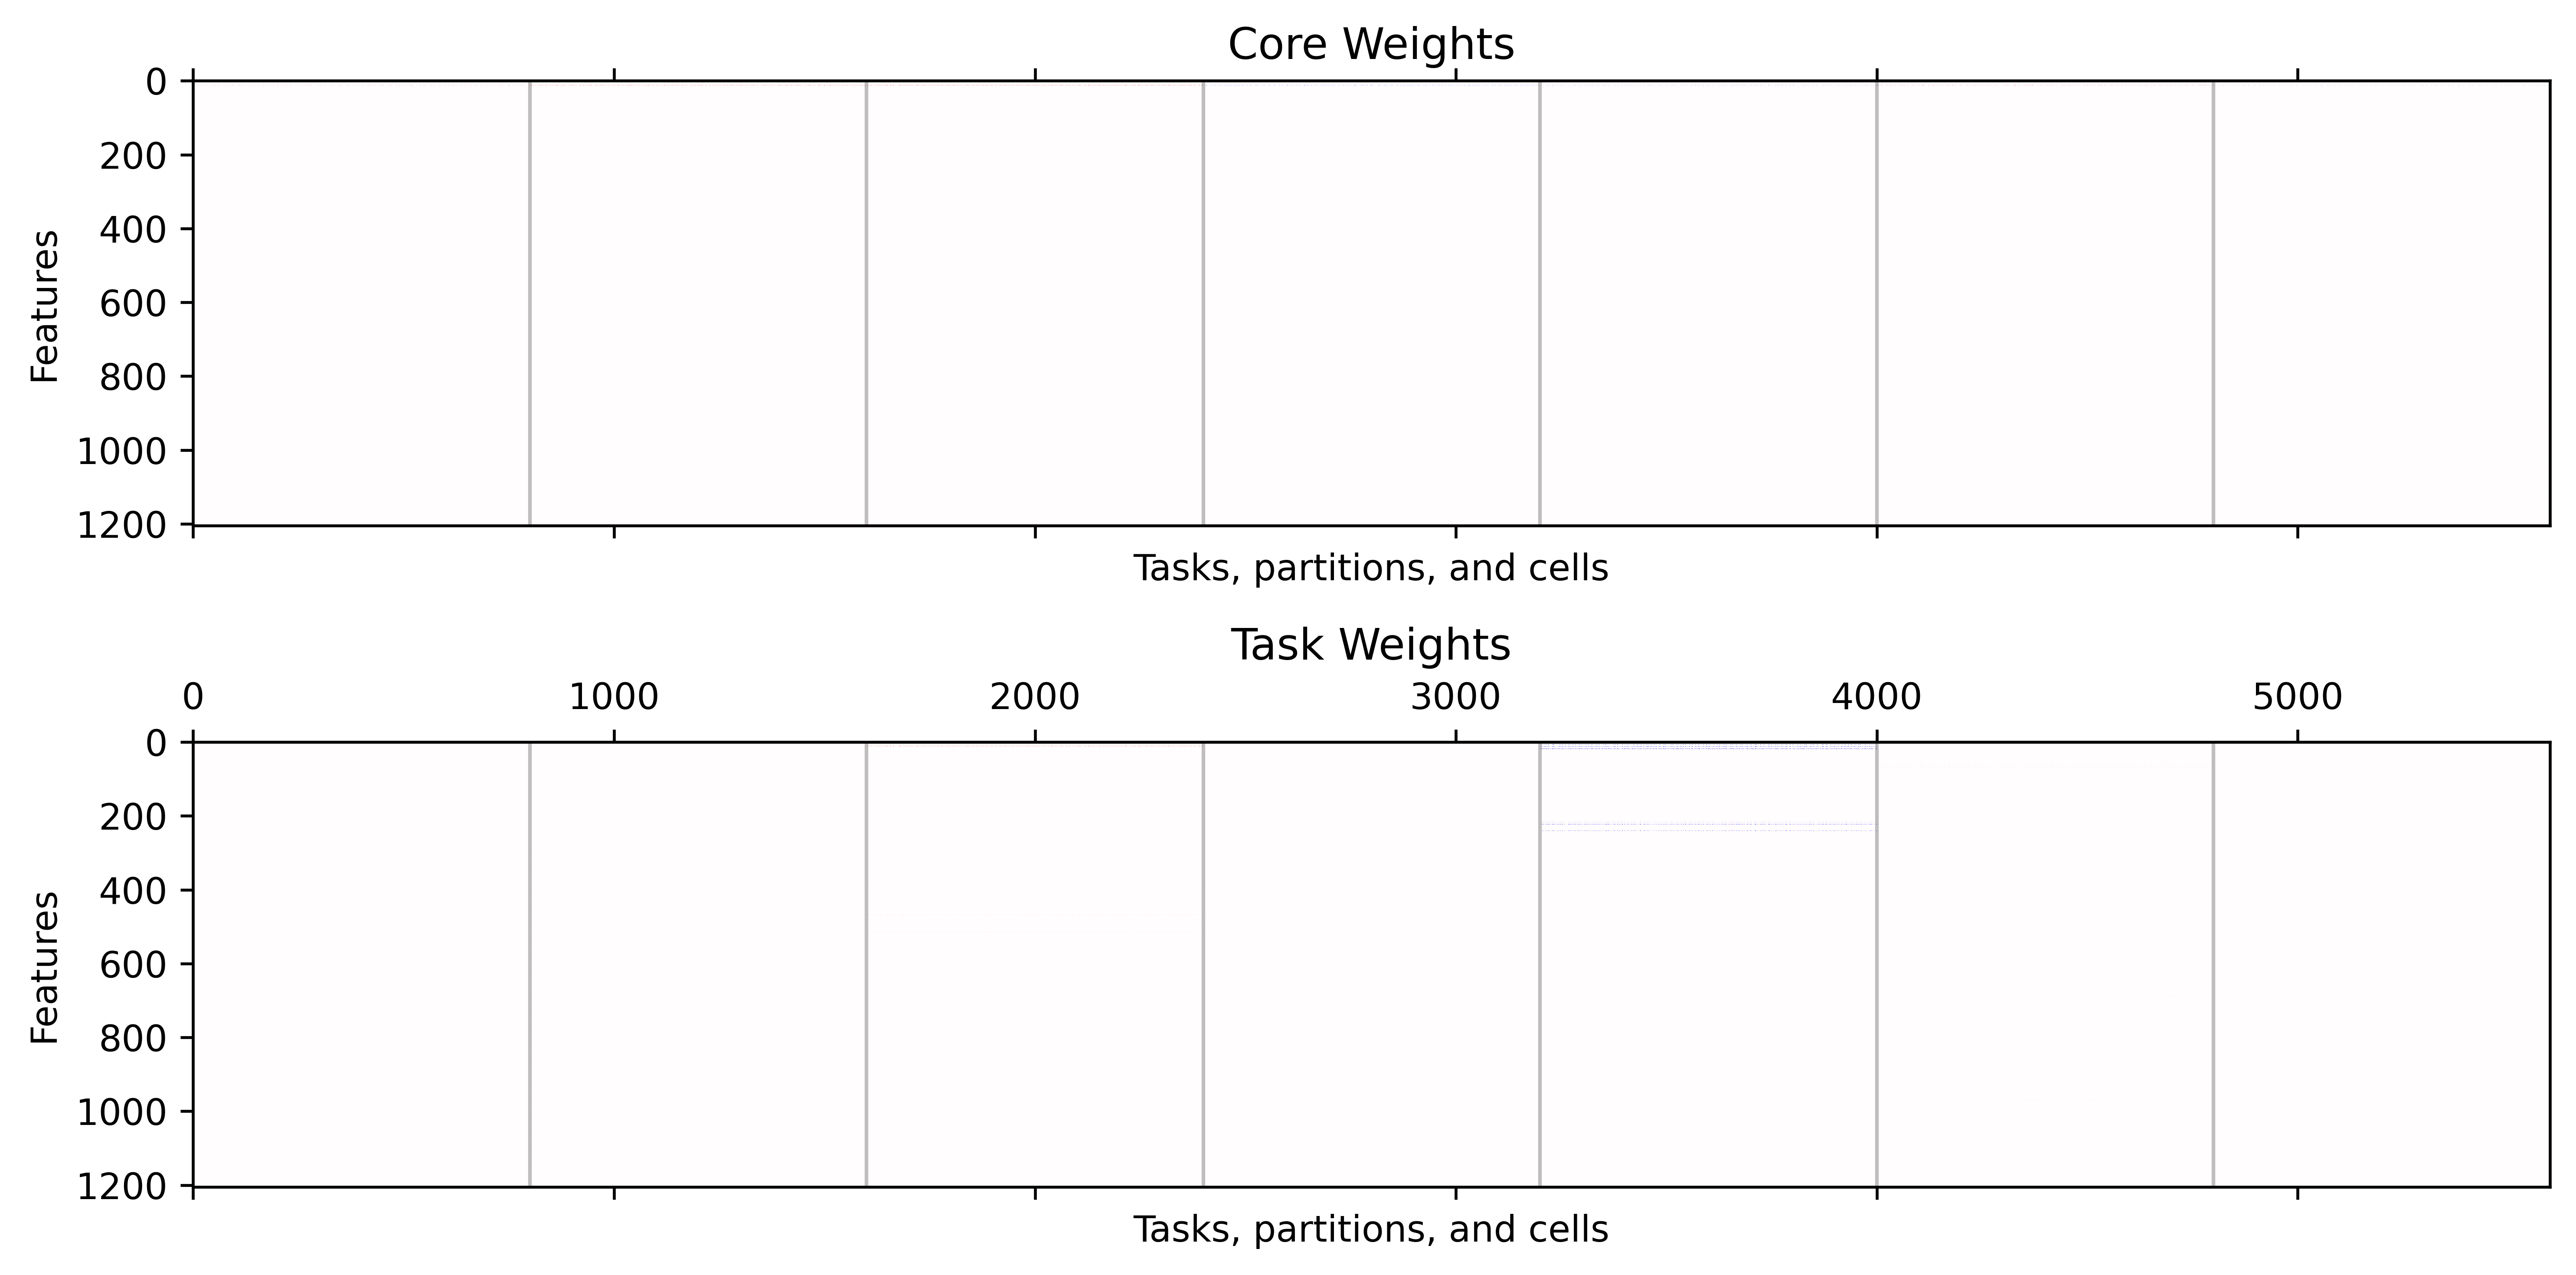

Number of nonzero core weights: 3
Number of nonzero task weights: [0, 0, 4, 0, 7, 47, 0]: 58


In [ ]:
jp_res = score_jp(jp_model, x_train, y_train, x_val, y_val, x_test, y_test)

display(jp_res.round(3))

plot_joplen_weights(jp_model, dpi=600)

In [ ]:
from mutar import DirtyModel

x_train_out, y_train_out, train_mask_out = concat_datasets(x_train, y_train)
x_val_out, y_val_out, val_mask_out = concat_datasets(x_val, y_val)
x_test_out, y_test_out, test_mask_out = concat_datasets(x_test, y_test)

dl_model = DirtyModel(
    alpha=0.03,  # shared penalty
    beta=0.02,  # task-specific penalty
)
dl_model.fit(x_train_out, y_train_out, train_mask_out)

# 6 minute training time

/home/matt/code/school/joplen/code/joplen-tests/my_env311/lib/python3.11/site-packages/mutar/solvers.py:44: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  warnings.warn('Objective did not converge.' +


DirtyModel(alpha=0.03, beta=0.02)

Core features: 15
Task features: [0, 0, 85, 7, 0, 0, 1]: 93


,train,val,test
task 0,0.841,0.777,0.602
task 1,0.746,0.611,0.595
task 2,0.409,0.419,0.402
task 3,0.664,0.688,0.648
task 4,0.977,1.136,1.353
task 5,0.979,1.458,1.036
task 6,0.953,0.986,0.938


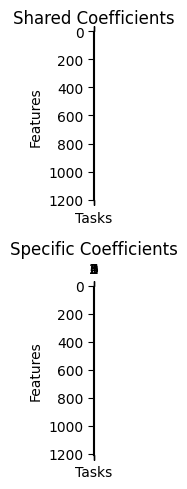

In [ ]:
dl_plot(dl_model)

dl_res = score_dl(
    dl_model,
    x_train_out,
    y_train_out,
    x_val_out,
    y_val_out,
    x_test_out,
    y_test_out,
    masks=[train_mask_out, val_mask_out, test_mask_out],
)
display(dl_res.round(3))

In [ ]:
feats_df = compare_feats(jp_model, dl_model)
feats_df

,task_0,task_1,task_2,task_3,task_4,task_5,task_6
JOPLEn,3,3,7,3,10,50,3
Dirty LASSO,15,15,100,22,15,15,16


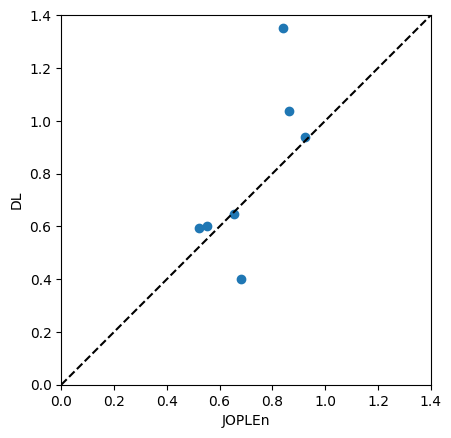

In [ ]:
scatter_test(jp_res, dl_res, "JOPLEn", "DL")

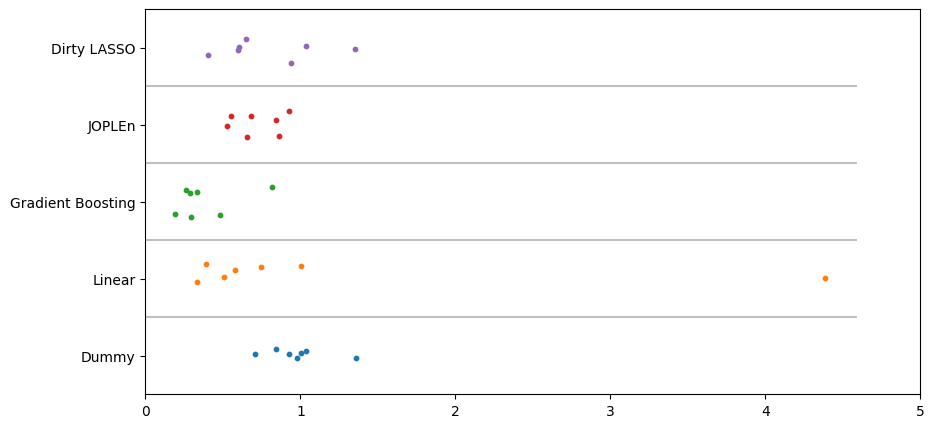

In [ ]:
scores = [dummy_results, linear_results, gb_results, jp_res, dl_res]
scores = np.array([s["test"].to_numpy() for s in scores])

plot_strip(
    scores,
    plot_kwargs={"figsize": (10, 5)},
    scatter_kwargs={"alpha": 1.0, "s": 10},
)
plt.yticks(np.arange(len(NAMES)), NAMES)


plt.xlim(0, 5)

plt.show()

In [ ]:
# save results for plotting
save_results(
    "nanoparticle",
    jp_res,
    dl_res,
    dummy_results,
    linear_results,
    gb_results,
    jp_model,
    dl_model,
)